In [782]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from random import choice
from typing import Union

from staff.hermes import Hermes
from analysis.analysts import *

from backtest.backtest_vector import Backtest 
from models.symbol import Symbol
from unit_tests._backtest_tester import test_vector

<b>Strategies to keep, use and take as basis for refined versions:</b>

- Pure Breakout
- Pure Trend
- To The Contrary

In [783]:
analyst = NoiseAnalyst()

NOISE_LOOKBACK = 30
MINIMUM_NO_OF_VALUES = 1000
NOISE_CALC_PERIOD = int(MINIMUM_NO_OF_VALUES / 10)


QUOTE_ASSET = 'USDT'
interval = '1h'
start = -1 * MINIMUM_NO_OF_VALUES
end = 'November 13, 2022 00:00:00'

strategy = 'To The Contrary'
leverage = 4
risk_level = 3
stop_loss_strategy = 'atr'
NOISE_CUTOFF = 0.05
INITIAL_CAPITAL = 1000

EXCLUDE_SYMBOLS = ['ARPA-USDT', 'BCHSV-USDT', 'BCHSV-BTC', 'EOS-USDT', 'BTT-USDT', 'DOT-USDT', 'VRA-USDT']

# my_symbols = ['BTC-USDT', 'ETH-USDT', 'BNB-USDT', 'SOL-USDT', 'ADA-USDT', 'XRP-USDT', 'ETC-USDT', 'DOGE-USDT', 'VET-USDT', 'ALGO-USDT']
my_symbols = ['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'SOLUSDT', 'ADAUSDT', 'XRPUSDT', 'ETCUSDT', 'DOGEUSDT', 'VETUSDT', 'ALGOUSDT']
# my_symbols = ['BTCUSDT', 'ETHUSDT', 'DOGEUSDT', 'VETUSDT']
# my_symbols = ['ETH-USDT', 'QNT-USDT']
USE_MY_SYMBOLS = True
EXCHANGE = 'kucoin'

In [784]:
def backtest(symbol_name):

    symbol = Symbol(symbol_name)
    
    initial_capital = INITIAL_CAPITAL / 1200 if 'BTC' in symbol_name[-3:] else INITIAL_CAPITAL

    state_params = {'long_allowed' : True,
                    'short_allowed' : True,
                    'initial_capital' : initial_capital,
                    'mode' : 'backtest'}

    bt = Backtest(symbol=symbol, 
                  interval=interval, 
                  strategy=strategy,
                  start=start, 
                  end=end, 
                  leverage=leverage,
                  risk_level=risk_level,
                  state_params=state_params,
                  stop_loss_strategy=stop_loss_strategy,
                  stoploss_params={'atr factor': 5},
                  verbose=False,
                  draw_chart=False)

    df = bt.run() 
  
    return df

In [785]:
h = Hermes(exchange=EXCHANGE, mode='backtest', verbose=False)
all_symbols = h.get_tradeable_symbols(quote_asset=QUOTE_ASSET, margin_only=True, remove_leveraged=True)
symbols = [s for s in all_symbols if not '3' in s]
symbols = [s for s in symbols if s not in EXCLUDE_SYMBOLS]
if USE_MY_SYMBOLS:
    symbols = my_symbols
raw_data = h.get_ohlcv(symbols=symbols, interval=interval, start=start, end=end)

In [786]:
data = []
try:
    for result in raw_data:
        if result['success']:
                df = result.get('message')
                
                if len(df) >= MINIMUM_NO_OF_VALUES:
                    df.drop(['open time', 'volume', 'quote asset volume', 'close time'], axis=1, inplace=True)
                    df.set_index('human open time', inplace=True)
                    
                    df = analyst.get_signal(df=df, lookback=NOISE_LOOKBACK, smoothing=1)
                    df['noise'].dropna(inplace=True)
                    
                    average_noise = np.mean(df['noise'])      
                    data.append([result.get('symbol'), average_noise, df])
                else:
                    print(result.get('symbol'), len(df))
except Exception as e:
    print(e)

VETUSDT 300


In [787]:
print(len(data))
data = sorted(data, key=lambda x: x[2]['noise'].median(), reverse=True)
dataframes = [item[2] for item in data]
df = pd.DataFrame(index=dataframes[0].index)

for item in data:
    symbol = item[0]
    item[2].dropna(inplace=True)
    noise = pd.DataFrame({symbol: item[2][:NOISE_CALC_PERIOD]['noise'].to_list()})
    median = noise.median()
    median_filter = True #(noise.median() > NOISE_CUTOFF).all()
    min_filter = (noise > 0).all()
    max_filter = (noise < 4).all()
    if  min_filter[0] and max_filter[0] and median_filter:
        df = df.join(noise, how='right')
        item.append(True)
    else:
        item.append(False)

9


<AxesSubplot:>

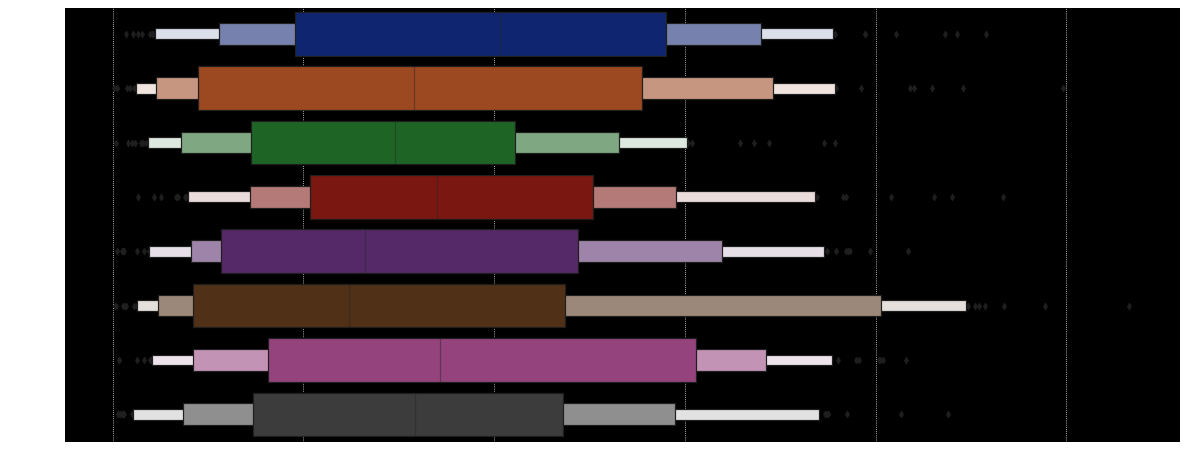

In [788]:
plt.figure(figsize=(20, 8))
plt.rcParams.update({"figure.dpi": 150})

sns.set_style("darkgrid", {'axes.facecolor': 'antiquewhite', "grid.color": '#0f0f0f', "grid.linestyle": ":"})
sns.set_palette("pastel")
sns.set_context('paper')
plt.style.use("dark_background")
# plt.style.use('Solarize_Light2')
sns.boxenplot(data=df, orient='h', palette='dark')

In [789]:
start = -1 * (MINIMUM_NO_OF_VALUES - NOISE_CALC_PERIOD)
backtest_data = []

for item in data:
    if not item[3]:
        continue
    symbol, df = item[0], item[2]
    _df = backtest(symbol)
    _df.set_index('human open time', inplace=True)
    backtest_data.append((symbol, 0, _df))
    
    %tb

SystemExit: 

SystemExit: 

SystemExit: 

SystemExit: 

SystemExit: 

SystemExit: 

SystemExit: 

SystemExit: 

In [ ]:
dataframes = [item[2] for item in backtest_data]
df_returns = pd.DataFrame(index=dataframes[0].index)
df_capital = pd.DataFrame(index=dataframes[0].index)
df_drawdowns = pd.DataFrame(index=dataframes[0].index)
counter = 0

for item in backtest_data:
    symbol, bt_result = item[0], item[2] 
    
    bt_result.ffill(inplace=True)
    bt_result.bfill(inplace=True)
    
    returns = pd.DataFrame({symbol: bt_result['b.value']}, index=bt_result.index)
    # returns.clip(lower=0)
    # returns.ffill(inplace=True)
    # returns.replace(np.nan, 0)
    
    _capital = pd.DataFrame({symbol: bt_result['capital']}, index=bt_result.index)
    _capital.fillna(method='bfill', inplace=True, )
    _capital.ffill(inplace=True)
    
    _drawdown = pd.DataFrame({symbol: bt_result['cptl.drawdown']}, index=bt_result.index) # 'cptl.drawdown'
    
    df_returns = df_returns.join(returns, how='left')
    df_capital = pd.concat([df_capital, _capital], join='outer', axis=1)
    df_drawdowns = df_drawdowns.join(_drawdown, how='left')
    counter += 1
    
df_returns = df_returns / counter
# df_returns.bfill(inplace=True)
gross_returns = df_returns.sum(axis = 1)

df_capital.bfill(inplace=True)
capital = df_capital.sum(axis=1)
capital = capital / counter

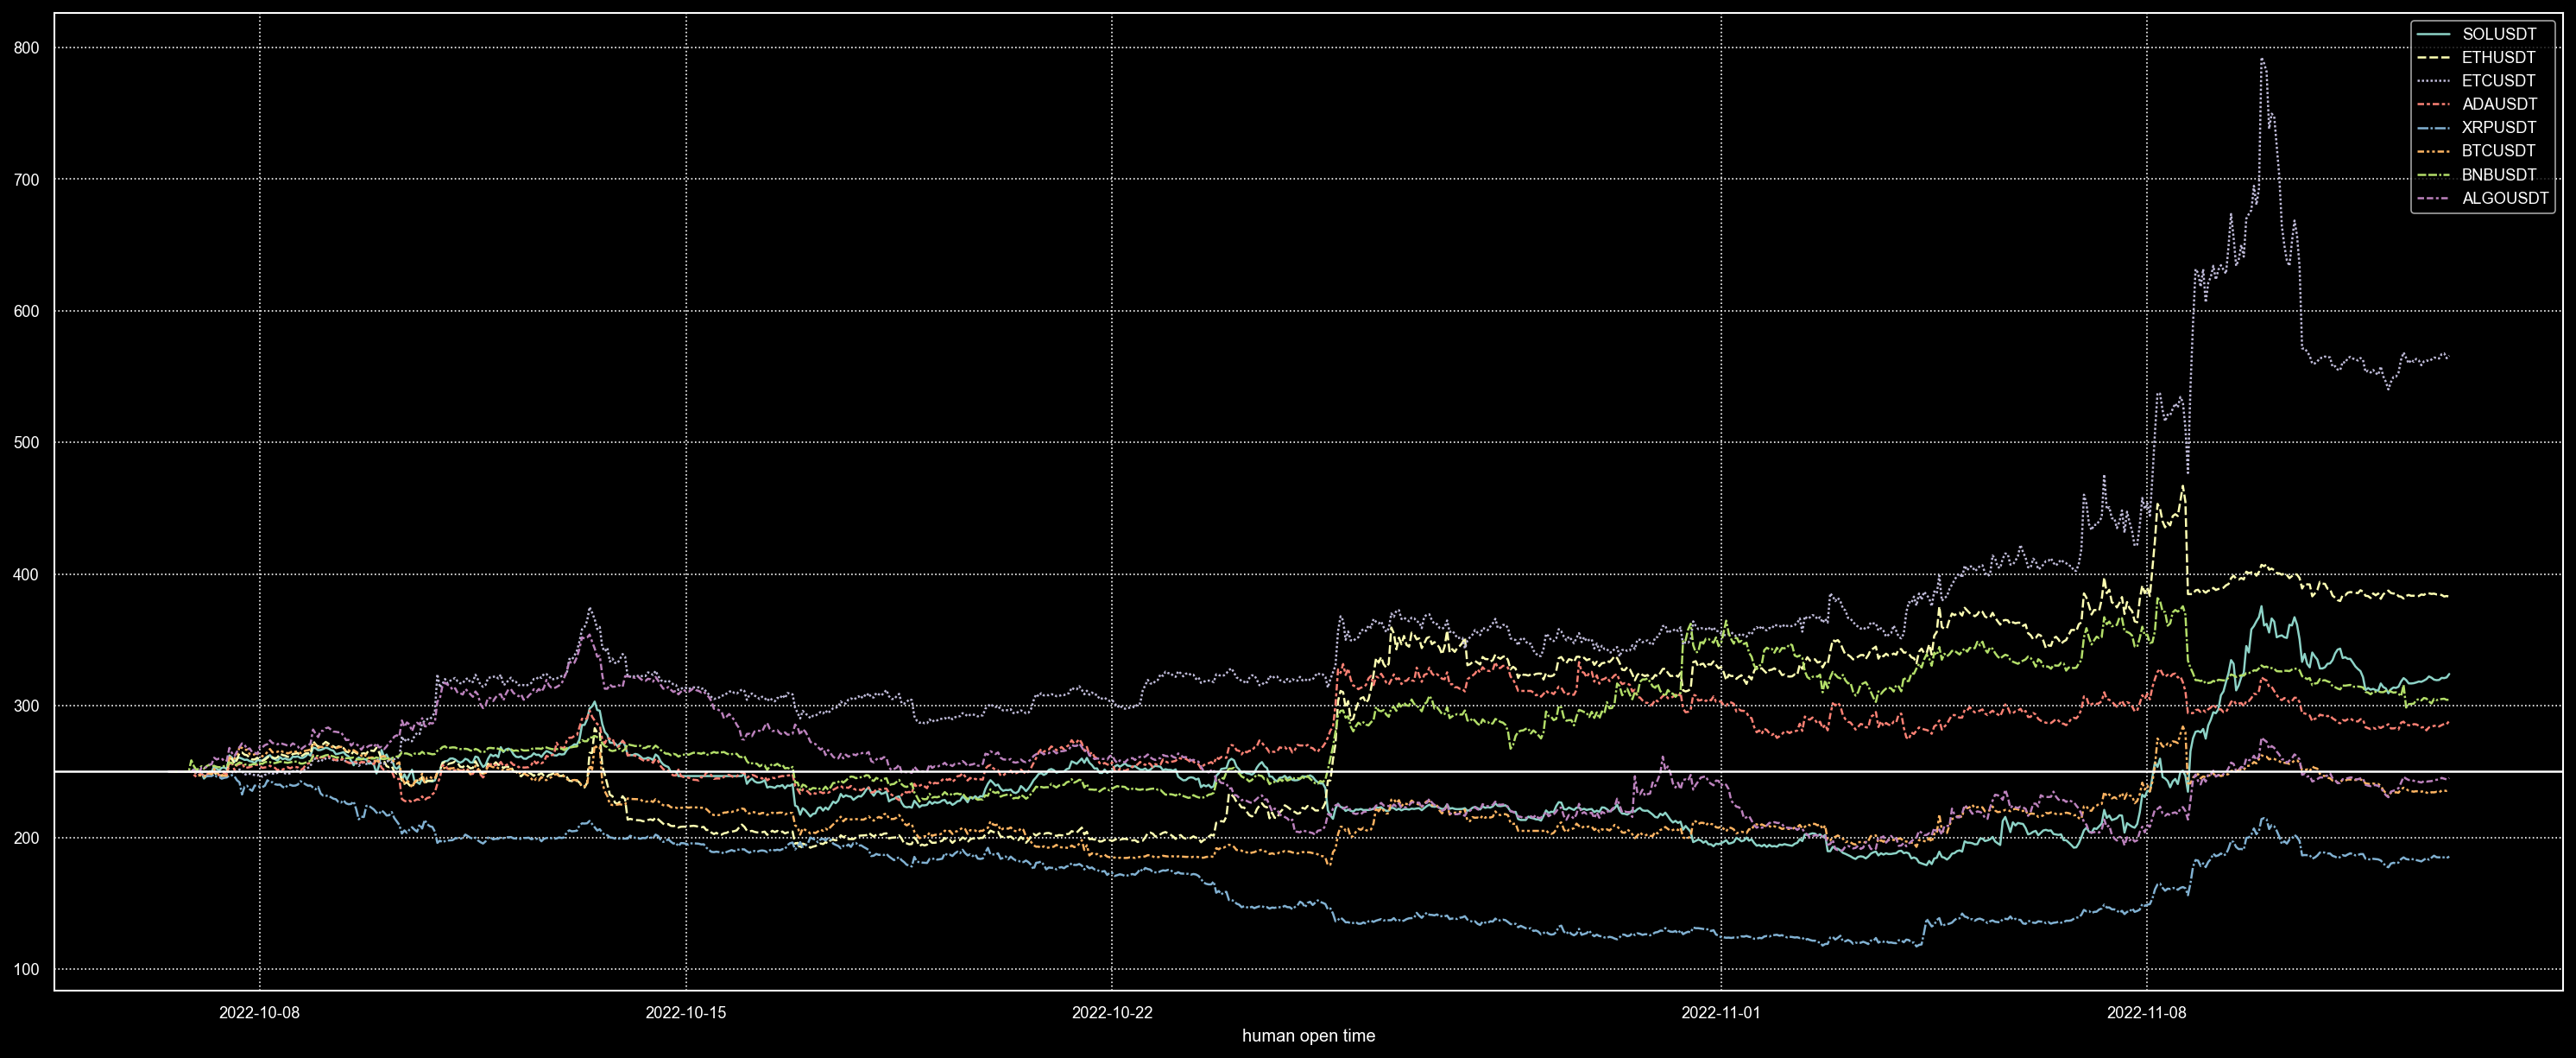

In [ ]:
plt.figure(figsize=(25, 10))
# plt.yscale('log')

df_returns.dropna()
df_returns.kurtosis()

graph = sns.lineplot(df_returns)
graph.axhline(INITIAL_CAPITAL / counter )
plt.show()

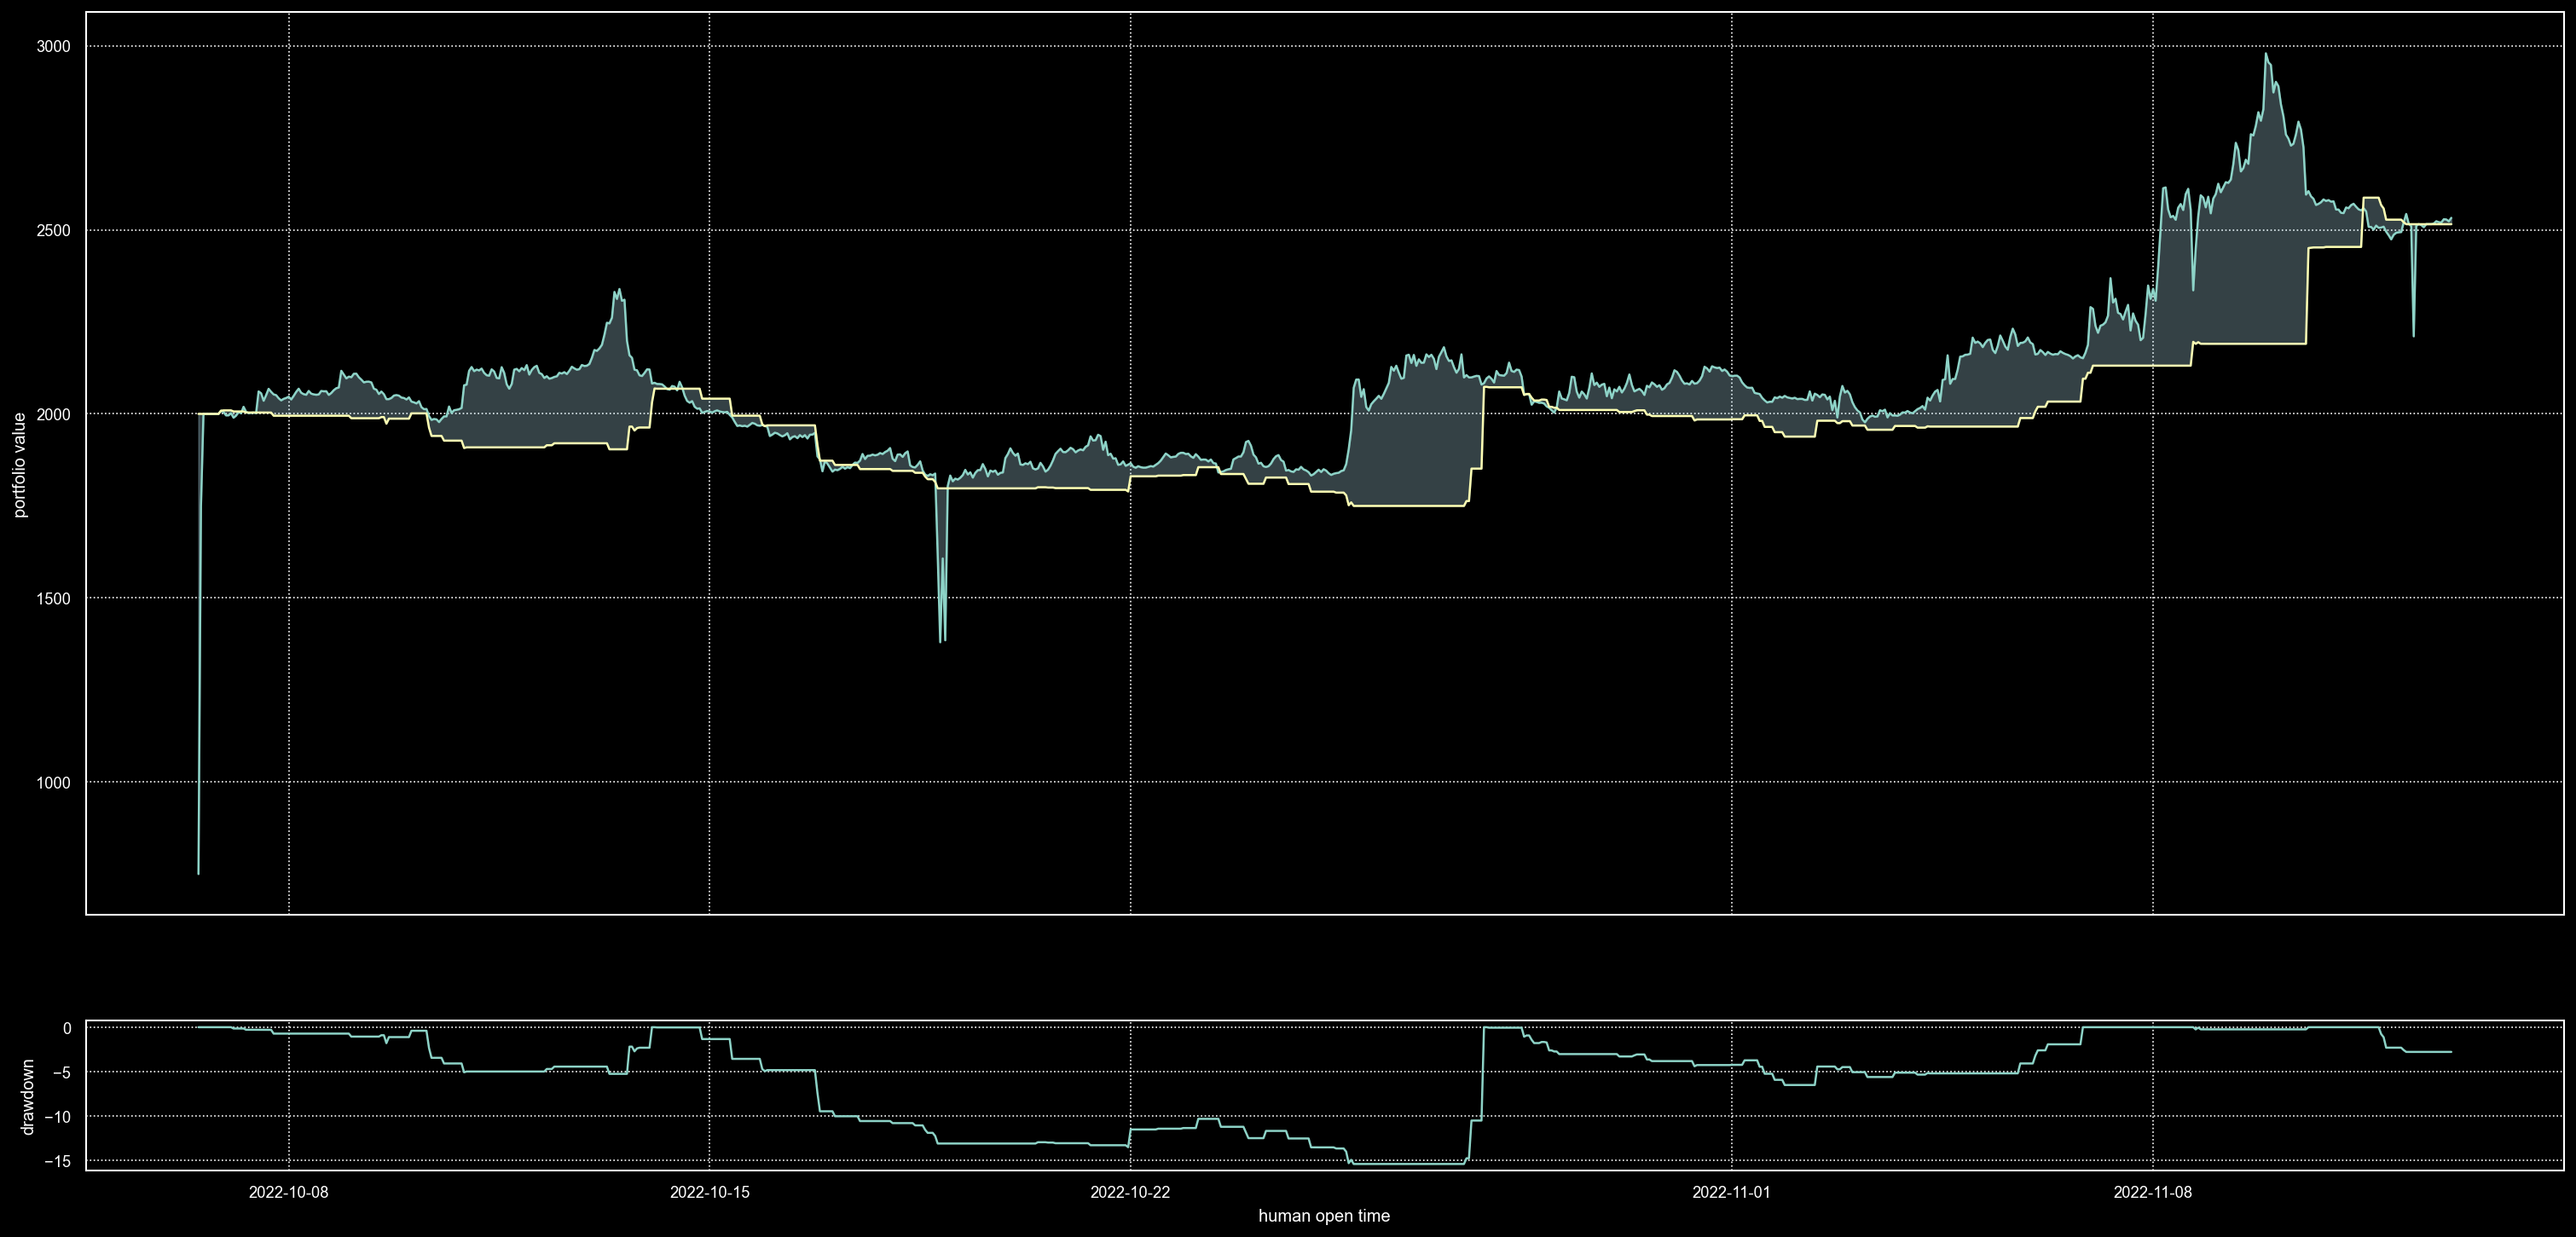

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(25, 12), sharex=True, gridspec_kw={'width_ratios': [1], 'height_ratios': [6, 1]})
df_plot =  pd.DataFrame(index=gross_returns.index)
df_plot['portfolio value'] = gross_returns 
df_plot['capital'] = capital # pd.concat([gross_returns, capital], axis=1)

df_plot['max'] = df_plot['capital'].expanding().max()
df_plot['drawdown'] = -100 * (1 - df_plot['capital'] / df_plot['max'])

axes[0].fill_between(x=df_plot.index, y1=df_plot['portfolio value'], y2=df_plot['capital'], color='lightblue', alpha=.3) # type: ignore
sns.lineplot(df_plot['portfolio value'], ax=axes[0])
sns.lineplot(df_plot['capital'], ax=axes[0])
sns.lineplot(df_plot['drawdown'], ax=axes[1])

plt.show()

skew: 23.732218565966285
kurtosis: 649.889148151254


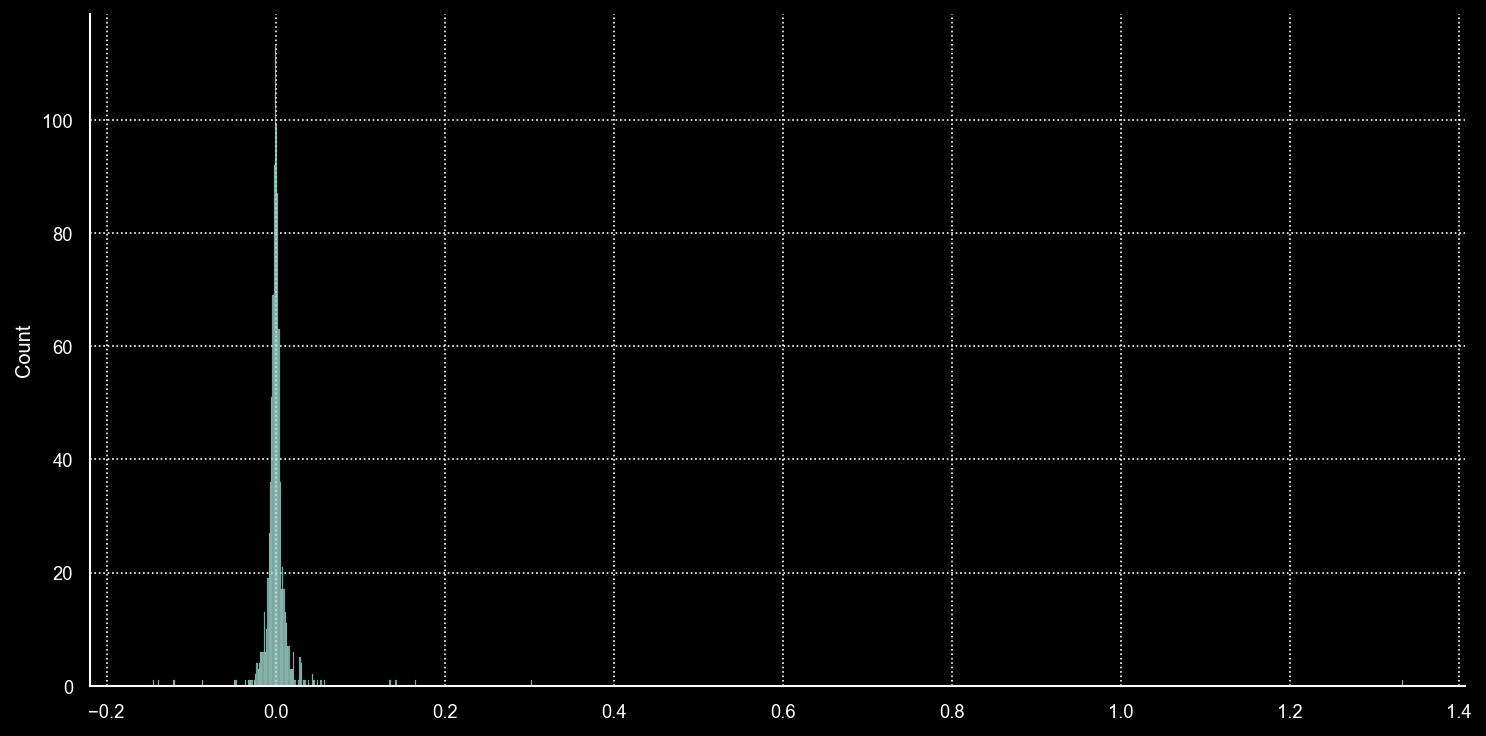

In [ ]:
gross_returns = gross_returns.pct_change()
print(f'skew: {gross_returns.skew()}')
print(f'kurtosis: {gross_returns.kurtosis()}')

sns.displot(data=gross_returns, height=5, aspect=2)

In [ ]:
df_returns.skew()

SOLUSDT     1.012694
ETHUSDT     0.154356
ETCUSDT     1.711131
ADAUSDT     0.168547
XRPUSDT     0.260738
BTCUSDT     0.361228
BNBUSDT     0.353495
ALGOUSDT    0.540422
dtype: float64

In [ ]:
# df_returns = df_returns.pct_change()
# df_returns.replace(np.nan, 0, inplace=True)
# plt.figure(figsize=(20, 10))
# sns.boxenplot(data=df_returns, showfliers=False)

In [ ]:
for item in backtest_data:
    if item[0] == 'ETCUSDT':
        print(item[2]['b.value'].tail(40))

human open time
2022-11-11 08:00:00    4520.322893
2022-11-11 09:00:00    4510.300866
2022-11-11 10:00:00    4505.289852
2022-11-11 11:00:00    4498.274433
2022-11-11 12:00:00    4513.307474
2022-11-11 13:00:00    4502.283244
2022-11-11 14:00:00    4428.120244
2022-11-11 15:00:00    4436.137865
2022-11-11 16:00:00    4425.113636
2022-11-11 17:00:00    4441.148879
2022-11-11 18:00:00    4422.107028
2022-11-11 19:00:00    4411.418408
2022-11-11 20:00:00    4461.787777
2022-11-11 21:00:00    4401.731991
2022-11-11 22:00:00    4368.798173
2022-11-11 23:00:00    4322.303371
2022-11-12 00:00:00    4366.860889
2022-11-12 01:00:00    4397.857424
2022-11-12 02:00:00    4399.794707
2022-11-12 03:00:00    4424.979392
2022-11-12 04:00:00    4502.470728
2022-11-12 05:00:00    4547.028247
2022-11-12 06:00:00    4514.094429
2022-11-12 07:00:00    4481.160611
2022-11-12 08:00:00    4502.470728
2022-11-12 09:00:00    4490.847028
2022-11-12 10:00:00    4508.282579
2022-11-12 11:00:00    4498.596162
2022

In [ ]:
df_returns.kurtosis()

SOLUSDT     1.107102
ETHUSDT    -1.342961
ETCUSDT     2.658471
ADAUSDT    -1.155983
XRPUSDT    -0.878010
BTCUSDT    -0.903560
BNBUSDT    -1.095973
ALGOUSDT   -0.257575
dtype: float64